# Qualitative Evaluation of Model

**Goal**: using a trained model, evaluate AUC scores for classes individually

1. Load model
2. Load dataset
3. Split dataset based on label
4. Evaluate the AUC score of the model on each label
5. Generate plot AUC scores.
6. Provide two examples where the model struggled and one where it succeeded 

In [1]:
import torch
from utils.dataset import MagnaTagATune
from model import Model
import os
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [2]:
# Move data to appropriate device
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print(f'Running model on device {DEVICE}')

MODEL_PATH = "../models/CNN_bs=10_lr=0.005_mom=0.99_model.pth"
model = Model(256, 256)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

Running model on device cpu


Model(
  (conv1): Conv1d(1, 32, kernel_size=(256,), stride=(256,))
  (conv2): Conv1d(32, 32, kernel_size=(8,), stride=(1,), padding=same)
  (pool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 32, kernel_size=(8,), stride=(1,), padding=same)
  (full1): Linear(in_features=256, out_features=100, bias=True)
  (full2): Linear(in_features=100, out_features=50, bias=True)
)

In [3]:
# Load the train and test datasets and create
dataset_root = os.path.join("..", "data", "MagnaTagATune")

test_labels_path = os.path.join(dataset_root, "annotations", "new_test_labels.pkl")
train_labels_path = os.path.join(dataset_root, "annotations", "new_train_labels.pkl")

samples_path = os.path.join(dataset_root, "samples")
test_dataset = MagnaTagATune(test_labels_path, samples_path)
train_dataset = MagnaTagATune(train_labels_path, samples_path)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    shuffle=False,
    pin_memory=True,
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=False,
    pin_memory=True,
)

Loading data from ../data/MagnaTagATune/annotations/new_test_labels.pkl...
Loading data from ../data/MagnaTagATune/annotations/new_train_labels.pkl...


In [4]:
all_preds = []

# No need to track gradients for validation, we're not optimizing.
with torch.no_grad():
    for _, batch, _ in test_loader:
        batch = batch.to(DEVICE)
        logits = model(batch)
        preds = logits.cpu().numpy()
        all_preds.extend(list(preds))

all_preds = torch.tensor(np.array(all_preds)).to(DEVICE)

/home/alex/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv1d(input, weight, bias, self.stride,


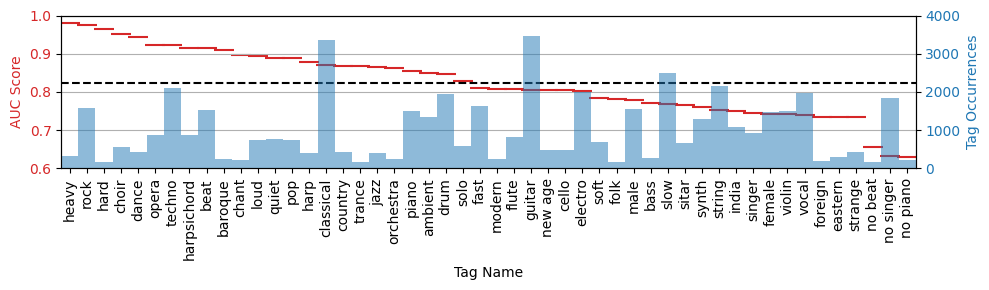

In [17]:
tag_names = {
 0: 'ambient',
 1: 'baroque',
 2: 'bass',
 3: 'beat',
 4: 'cello',
 5: 'chant',
 6: 'choir',
 7: 'classical',
 8: 'country',
 9: 'dance',
 10: 'drum',
 11: 'eastern',
 12: 'electro',
 13: 'fast',
 14: 'female',
 15: 'flute',
 16: 'folk',
 17: 'foreign',
 18: 'guitar',
 19: 'hard',
 20: 'harp',
 21: 'harpsichord',
 22: 'heavy',
 23: 'india',
 24: 'jazz',
 25: 'loud',
 26: 'male',
 27: 'modern',
 28: 'new age',
 29: 'no beat',
 30: 'no piano',
 31: 'no singer',
 32: 'opera',
 33: 'orchestra',
 34: 'piano',
 35: 'pop',
 36: 'quiet',
 37: 'rock',
 38: 'singer',
 39: 'sitar',
 40: 'slow',
 41: 'soft',
 42: 'solo',
 43: 'strange',
 44: 'string',
 45: 'synth',
 46: 'techno',
 47: 'trance',
 48: 'violin',
 49: 'vocal'
}

gts = pd.read_pickle(test_labels_path)

test_labels = []
for i in range(len(gts.iloc[:]['label'])):
    # labels.append(gts[i][2].numpy())                             # A 50D Ground Truth binary vector
    test_labels.append(np.array(gts.iloc[i]['label']).astype(float))    # A 50D Ground Truth binary vector
    # model_outs.append(preds[i].cpu().numpy()) # A 50D vector that assigns probability to each class
test_labels = np.array(test_labels).astype(float)


gts = pd.read_pickle(train_labels_path)

train_labels = []
for i in range(len(gts.iloc[:]['label'])):
    # labels.append(gts[i][2].numpy())                             # A 50D Ground Truth binary vector
    train_labels.append(np.array(gts.iloc[i]['label']).astype(float))    # A 50D Ground Truth binary vector
    # model_outs.append(preds[i].cpu().numpy()) # A 50D vector that assigns probability to each class
train_labels = np.array(train_labels).astype(float)

tag_auc_scores = []


tag_auc_scores = roc_auc_score(y_true=test_labels, y_score=all_preds, multi_class='ovr', average=None)
auc_score = roc_auc_score(y_true=test_labels, y_score=all_preds)

occurrences = [np.count_nonzero(train_labels[:, i]) for i in range(50)]

tags = np.array(range(50))
idx = np.argsort(tag_auc_scores)[::-1]
tag_auc_scores = tag_auc_scores[idx]
tags = tags[idx]
tag_names = list(map(lambda x: tag_names[x], tags))
occurrences = np.array(occurrences)[idx]

fig, ax1 = plt.subplots(figsize=(10, 3))

color = 'tab:red'
ax1.set_xlabel('Tag Name')
ax1.set_ylabel('AUC Score', color=color)
ax1.scatter(range(50), tag_auc_scores, s=190, marker = "_", label="AUC score per tag", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(range(50), tag_names, rotation = 90, fontsize=10)
ax1.set_yticks(np.linspace(0.6, 1.0, 5))
ax1.axhline(y = auc_score, color="black", ls="--", label="Average AUC score") 
ax1.grid(axis = 'y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Tag Occurrences', color=color)  # we already handled the x-label with ax1
ax2.bar(range(50), occurrences, color=color, alpha=0.5, width=1.0)
ax2.set_yticks(np.linspace(4000, 0, 5))
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.margins(x=0)
plt.show()